# PCA on Vibration Data
This notebook loads all RECOVERY.npz files, performs PCA to reduce the data to 2 dimensions, and visualizes the results labeled by cube position.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path
import sys
import types
import os
import re
from glob import glob

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Load all RECOVERY.npz files

In [15]:
# Patch for pickle loading
def compute_CAM2_translations_v3_cupy(*args, **kwargs):
    return None

if 'recover_core_lib' in sys.modules:
    sys.modules['recover_core_lib'].compute_CAM2_translations_v3_cupy = compute_CAM2_translations_v3_cupy
else:
    fake = types.ModuleType('recover_core_lib')
    fake.compute_CAM2_translations_v3_cupy = compute_CAM2_translations_v3_cupy
    sys.modules['recover_core_lib'] = fake

# Find all RECOVERY.npz files
data_dir = Path('/Users/eitanturok/good-vibrations/data/vibrations')
recovery_files = sorted(glob(str(data_dir / '*/RECOVERY.npz')))

print(f"Found {len(recovery_files)} RECOVERY.npz files:")
for f in recovery_files:
    print(f"  - {f}")

Found 8 RECOVERY.npz files:
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos1_29_12_Time_19_16_40/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos2_29_12_Time_19_03_39/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos2_29_12_Time_19_13_50/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos3_29_12_Time_19_27_21/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos3_29_12_Time_19_29_43/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos4_29_12_Time_19_24_21/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos5_29_12_Time_19_22_12/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos6_29_12_Time_19_20_07/RECOVERY.npz


In [16]:
def extract_cube_position(filepath):
    """Extract cube position from filepath like 'cube_pos1_29_12_Time_19_16_40'"""
    dirname = Path(filepath).parent.name
    match = re.search(r'cube_pos(\d+)', dirname)
    if match:
        return int(match.group(1))
    return None

# Load all data
all_data = []
all_positions = []
all_filenames = []

for filepath in recovery_files:
    recovery_data = np.load(filepath, allow_pickle=True)
    all_shifts = recovery_data['all_shifts']
    run_opt = recovery_data['run_opt'].item()

    # Remove first time point if needed (based on original notebook)
    all_shifts = all_shifts[:, 1:]

    cube_pos = extract_cube_position(filepath)

    all_data.append(all_shifts)
    all_positions.append(cube_pos)
    all_filenames.append(filepath)

    print(f"Loaded {filepath}")
    print(f"  - Cube position: {cube_pos}")
    print(f"  - Shape: {all_shifts.shape}")
    print(f"  - fs: {run_opt['cam_params']['camera_FPS']} Hz")
    print()

Loaded /Users/eitanturok/good-vibrations/data/vibrations/cube_pos1_29_12_Time_19_16_40/RECOVERY.npz
  - Cube position: 1
  - Shape: (100, 29999, 2)
  - fs: 5000 Hz

Loaded /Users/eitanturok/good-vibrations/data/vibrations/cube_pos2_29_12_Time_19_03_39/RECOVERY.npz
  - Cube position: 2
  - Shape: (100, 29999, 2)
  - fs: 5000 Hz

Loaded /Users/eitanturok/good-vibrations/data/vibrations/cube_pos2_29_12_Time_19_13_50/RECOVERY.npz
  - Cube position: 2
  - Shape: (100, 29999, 2)
  - fs: 5000 Hz

Loaded /Users/eitanturok/good-vibrations/data/vibrations/cube_pos3_29_12_Time_19_27_21/RECOVERY.npz
  - Cube position: 3
  - Shape: (100, 29999, 2)
  - fs: 5000 Hz

Loaded /Users/eitanturok/good-vibrations/data/vibrations/cube_pos3_29_12_Time_19_29_43/RECOVERY.npz
  - Cube position: 3
  - Shape: (100, 29999, 2)
  - fs: 5000 Hz

Loaded /Users/eitanturok/good-vibrations/data/vibrations/cube_pos4_29_12_Time_19_24_21/RECOVERY.npz
  - Cube position: 4
  - Shape: (100, 29999, 2)
  - fs: 5000 Hz

Loaded /Us

## Prepare data for PCA
Flatten each recording into a single feature vector and stack them together.

In [17]:
# Option 1: Use FFT magnitude spectrum as features (more robust to time shifts)
# Option 2: Use flattened time series

USE_FFT = True  # Set to False to use raw time series

feature_vectors = []

for shifts in all_data:
    # shifts shape: (n_sensors, n_timesteps, 2)
    n_sensors, n_timesteps, n_dims = shifts.shape

    if USE_FFT:
        # Compute FFT magnitude for each sensor/dimension
        fft_mag = np.abs(np.fft.rfft(shifts, axis=1))
        # Flatten: (n_sensors * n_freq_bins * 2)
        feature_vec = fft_mag.flatten()
    else:
        # Flatten the raw time series
        feature_vec = shifts.flatten()

    feature_vectors.append(feature_vec)

# Find minimum length and truncate to make uniform
min_len = min(len(fv) for fv in feature_vectors)
feature_vectors = [fv[:min_len] for fv in feature_vectors]

# Stack into matrix
X = np.vstack(feature_vectors)
positions = np.array(all_positions)

print(f"Feature matrix shape: {X.shape}")
print(f"Positions: {positions}")

Feature matrix shape: (8, 3000000)
Positions: [1 2 2 3 3 4 5 6]


## Perform PCA

In [18]:
# Standardize features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1  # Avoid division by zero
X_normalized = (X - X_mean) / X_std

# PCA to 2 dimensions
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_normalized)

print(f"PCA result shape: {X_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

PCA result shape: (8, 2)
Explained variance ratio: [0.18456748 0.15780833]
Total variance explained: 34.24%


## Visualize PCA results

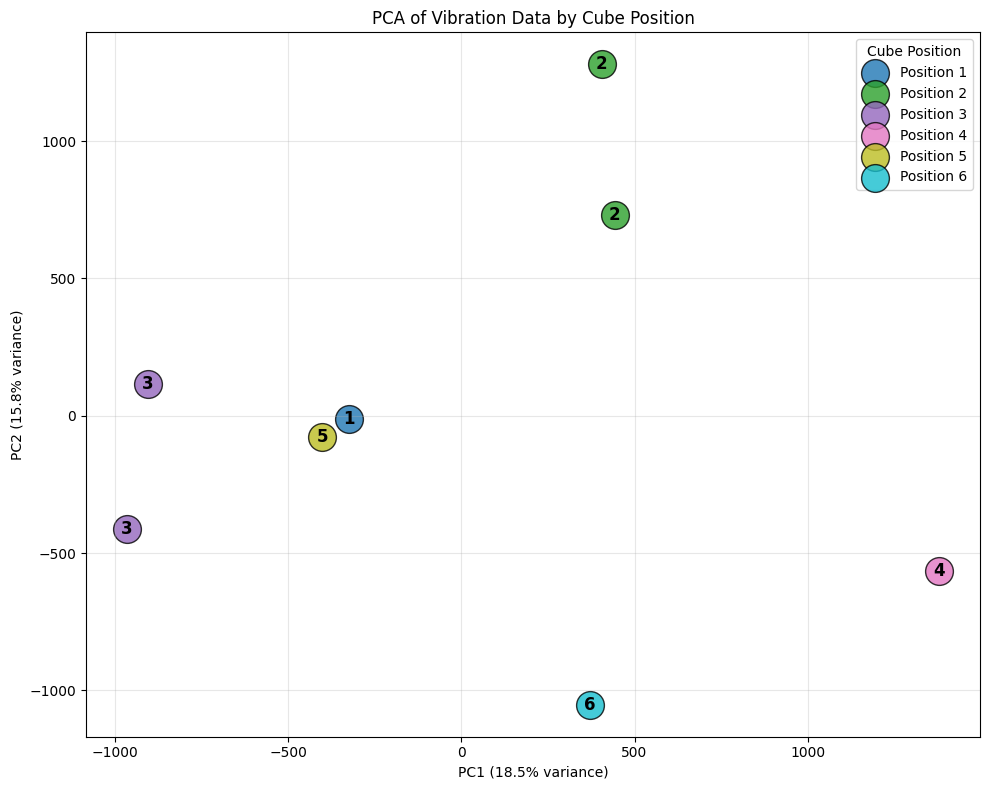

In [19]:
# Create color map for cube positions
unique_positions = np.unique(positions)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_positions)))
color_map = {pos: colors[i] for i, pos in enumerate(unique_positions)}

fig, ax = plt.subplots(figsize=(10, 8))

for pos in unique_positions:
    mask = positions == pos
    ax.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        c=[color_map[pos]],
        label=f'Position {pos}',
        s=400,
        alpha=0.8,
        edgecolors='black',
        linewidths=1
    )

# Add position number inside each circle
for i, (x, y) in enumerate(X_pca):
    ax.text(
        x, y, str(positions[i]),
        fontsize=12,
        fontweight='bold',
        ha='center',
        va='center',
        color='black'
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('PCA of Vibration Data by Cube Position')
ax.legend(title='Cube Position', loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Additional visualization: PCA with more components

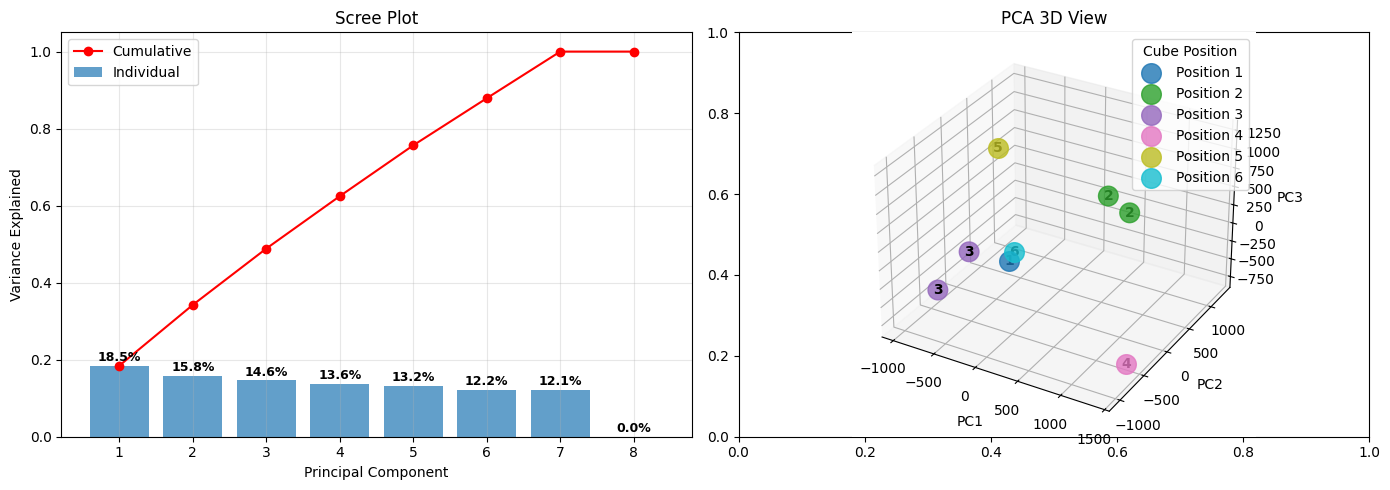

In [20]:
# PCA with more components to see variance explained
pca_full = PCA(n_components=min(8, X.shape[0]), random_state=RANDOM_SEED)
X_pca_full = pca_full.fit_transform(X_normalized)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
ax = axes[0]
bars = ax.bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
              pca_full.explained_variance_ratio_,
              alpha=0.7, label='Individual')
ax.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
        np.cumsum(pca_full.explained_variance_ratio_),
        'r-o', label='Cumulative')

# Add variance percentage on each bar
for i, (bar, var) in enumerate(zip(bars, pca_full.explained_variance_ratio_)):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
            f'{var:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained')
ax.set_title('Scree Plot')
ax.legend()
ax.grid(True, alpha=0.3)

# 3D plot if we have at least 3 components
if X_pca_full.shape[1] >= 3:
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    for pos in unique_positions:
        mask = positions == pos
        ax.scatter(
            X_pca_full[mask, 0],
            X_pca_full[mask, 1],
            X_pca_full[mask, 2],
            c=[color_map[pos]],
            label=f'Position {pos}',
            s=200,
            alpha=0.8
        )

    # Add position labels to each point
    for i in range(len(positions)):
        ax.text(
            X_pca_full[i, 0],
            X_pca_full[i, 1],
            X_pca_full[i, 2],
            str(positions[i]),
            fontsize=10,
            fontweight='bold',
            ha='center',
            va='center',
            color='black'
        )

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('PCA 3D View')
    ax.legend(title='Cube Position')

plt.tight_layout()
plt.show()

## Summary table

In [21]:
print("Summary of loaded data:")
print("=" * 80)
print(f"{'File':<50} {'Position':<10} {'PC1':>8} {'PC2':>8}")
print("-" * 80)
for i, (fname, pos) in enumerate(zip(all_filenames, positions)):
    dirname = Path(fname).parent.name
    print(f"{dirname:<50} {pos:<10} {X_pca[i, 0]:>8.2f} {X_pca[i, 1]:>8.2f}")
print("=" * 80)

Summary of loaded data:
File                                               Position        PC1      PC2
--------------------------------------------------------------------------------
cube_pos1_29_12_Time_19_16_40                      1           -324.26   -12.60
cube_pos2_29_12_Time_19_03_39                      2            443.25   729.13
cube_pos2_29_12_Time_19_13_50                      2            404.95  1279.44
cube_pos3_29_12_Time_19_27_21                      3           -967.34  -413.64
cube_pos3_29_12_Time_19_29_43                      3           -906.85   115.43
cube_pos4_29_12_Time_19_24_21                      4           1380.60  -566.08
cube_pos5_29_12_Time_19_22_12                      5           -402.07   -79.30
cube_pos6_29_12_Time_19_20_07                      6            371.72 -1052.37


## Distance Matrix with Ordering Validation

Constraint: Samples from the same position must be closest to each other in embedding space.
- Position 2 has samples at indices 1 and 2
- Position 3 has samples at indices 3 and 4

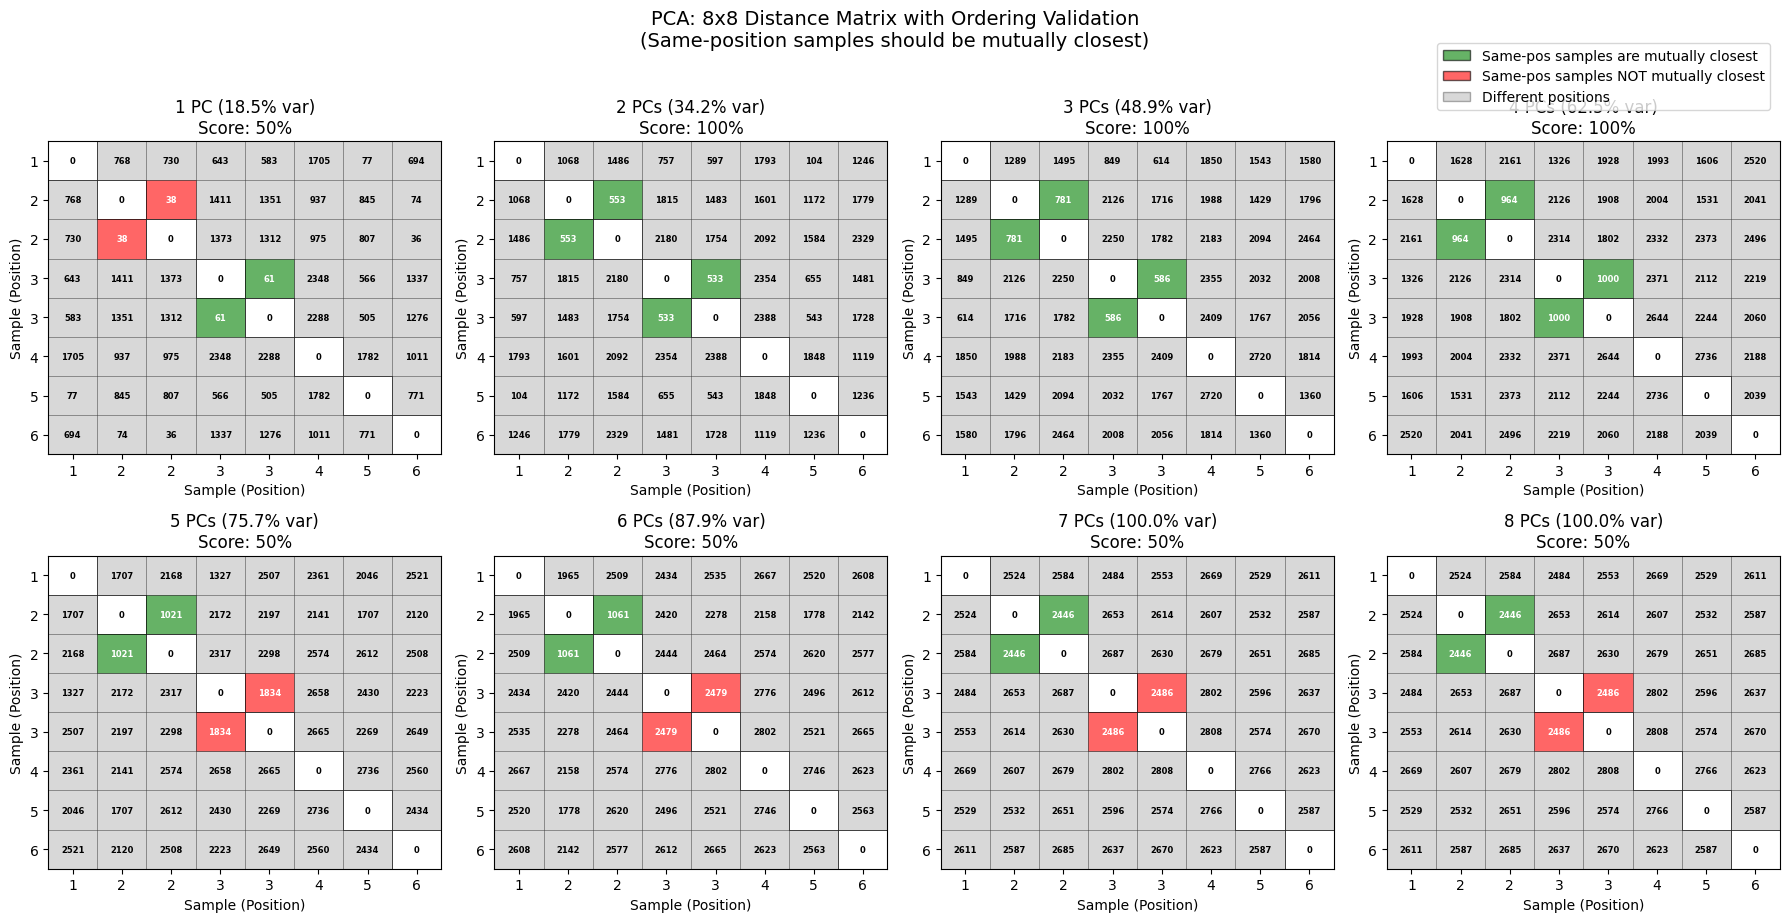


PCA Scores (same-position samples mutually closest):
  1 PC : 50%
  2 PCs: 100%
  3 PCs: 100%
  4 PCs: 100%
  5 PCs: 50%
  6 PCs: 50%
  7 PCs: 50%
  8 PCs: 50%


In [22]:
from scipy.spatial.distance import cdist

def compute_sample_distance_matrix(X_embedded):
    """Compute pairwise distance between all samples in embedded space."""
    return cdist(X_embedded, X_embedded, metric='euclidean')

def check_same_position_closest(dist_matrix, positions):
    """
    Check if samples from the same position are closest to each other.
    Returns: (score, cell_status_matrix)
    - score: fraction of same-position pairs that are mutually closest
    - cell_status_matrix: 1=correct, -1=incorrect, 0=not applicable
    """
    n = len(positions)
    status = np.zeros((n, n))
    n_constraints = 0
    n_correct = 0

    # Find pairs of samples with the same position
    for i in range(n):
        for j in range(i + 1, n):
            if positions[i] == positions[j]:
                n_constraints += 1
                # Check if j is the closest to i (excluding i itself)
                dist_from_i = dist_matrix[i].copy()
                dist_from_i[i] = np.inf  # exclude self
                closest_to_i = np.argmin(dist_from_i)

                # Check if i is the closest to j (excluding j itself)
                dist_from_j = dist_matrix[j].copy()
                dist_from_j[j] = np.inf  # exclude self
                closest_to_j = np.argmin(dist_from_j)

                # Both must be mutually closest
                if closest_to_i == j and closest_to_j == i:
                    status[i, j] = 1
                    status[j, i] = 1
                    n_correct += 1
                else:
                    status[i, j] = -1
                    status[j, i] = -1

    score = n_correct / n_constraints if n_constraints > 0 else 1.0
    return score, status

# Sample labels for the 8x8 matrix
sample_labels = positions  # [1, 2, 2, 3, 3, 4, 5, 6]

# Compute PCA with all components
max_components = min(8, X.shape[0])
pca_all = PCA(n_components=max_components, random_state=RANDOM_SEED)
X_pca_all = pca_all.fit_transform(X_normalized)

# Create distance matrices with ordering validation for different numbers of PCs
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

pca_scores = []

for n_pcs in range(1, max_components + 1):
    ax = axes[n_pcs - 1]
    X_subset = X_pca_all[:, :n_pcs]
    dist_matrix = compute_sample_distance_matrix(X_subset)
    score, status_matrix = check_same_position_closest(dist_matrix, positions)
    pca_scores.append(score)

    n_samples = len(sample_labels)

    # Plot with colored cells based on status
    for i in range(n_samples):
        for j in range(n_samples):
            if i == j:
                color, alpha = 'white', 1.0
            elif status_matrix[i, j] == 1:
                color, alpha = 'green', 0.6
            elif status_matrix[i, j] == -1:
                color, alpha = 'red', 0.6
            else:
                color, alpha = 'gray', 0.3

            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                  facecolor=color, alpha=alpha, edgecolor='black', linewidth=0.5)
            ax.add_patch(rect)

            text_color = 'white' if status_matrix[i, j] != 0 else 'black'
            ax.text(j, i, f'{dist_matrix[i, j]:.0f}',
                   ha='center', va='center', color=text_color, fontsize=6, fontweight='bold')

    ax.set_xticks(range(n_samples))
    ax.set_yticks(range(n_samples))
    ax.set_xticklabels(sample_labels)
    ax.set_yticklabels(sample_labels)
    ax.set_xlabel('Sample (Position)')
    ax.set_ylabel('Sample (Position)')
    ax.set_title(f'{n_pcs} PC{"s" if n_pcs > 1 else ""} ({pca_all.explained_variance_ratio_[:n_pcs].sum():.1%} var)\nScore: {score:.0%}')
    ax.set_xlim(-0.5, n_samples - 0.5)
    ax.set_ylim(n_samples - 0.5, -0.5)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.6, edgecolor='black', label='Same-pos samples are mutually closest'),
    Patch(facecolor='red', alpha=0.6, edgecolor='black', label='Same-pos samples NOT mutually closest'),
    Patch(facecolor='gray', alpha=0.3, edgecolor='black', label='Different positions')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99))

plt.suptitle('PCA: 8x8 Distance Matrix with Ordering Validation\n(Same-position samples should be mutually closest)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nPCA Scores (same-position samples mutually closest):")
for n_pcs, score in enumerate(pca_scores, 1):
    print(f"  {n_pcs} PC{'s' if n_pcs > 1 else ' '}: {score:.0%}")

---
# t-SNE Analysis

Now we repeat the same analysis using t-SNE instead of PCA.

In [23]:
from sklearn.manifold import TSNE

# First reduce dimensionality with PCA before t-SNE (recommended for high-dim data)
n_pca_components = 50  # Reduce to 50 dims first, then t-SNE
pca_pre = PCA(n_components=min(n_pca_components, X.shape[0] - 1), random_state=RANDOM_SEED)
X_pca_pre = pca_pre.fit_transform(X_normalized)

print(f"Pre-PCA reduced shape: {X_pca_pre.shape}")
print(f"Variance retained: {pca_pre.explained_variance_ratio_.sum():.2%}")

Pre-PCA reduced shape: (8, 7)
Variance retained: 100.00%


## t-SNE with different perplexity values

Perplexity is a key hyperparameter in t-SNE that controls the balance between local and global structure.

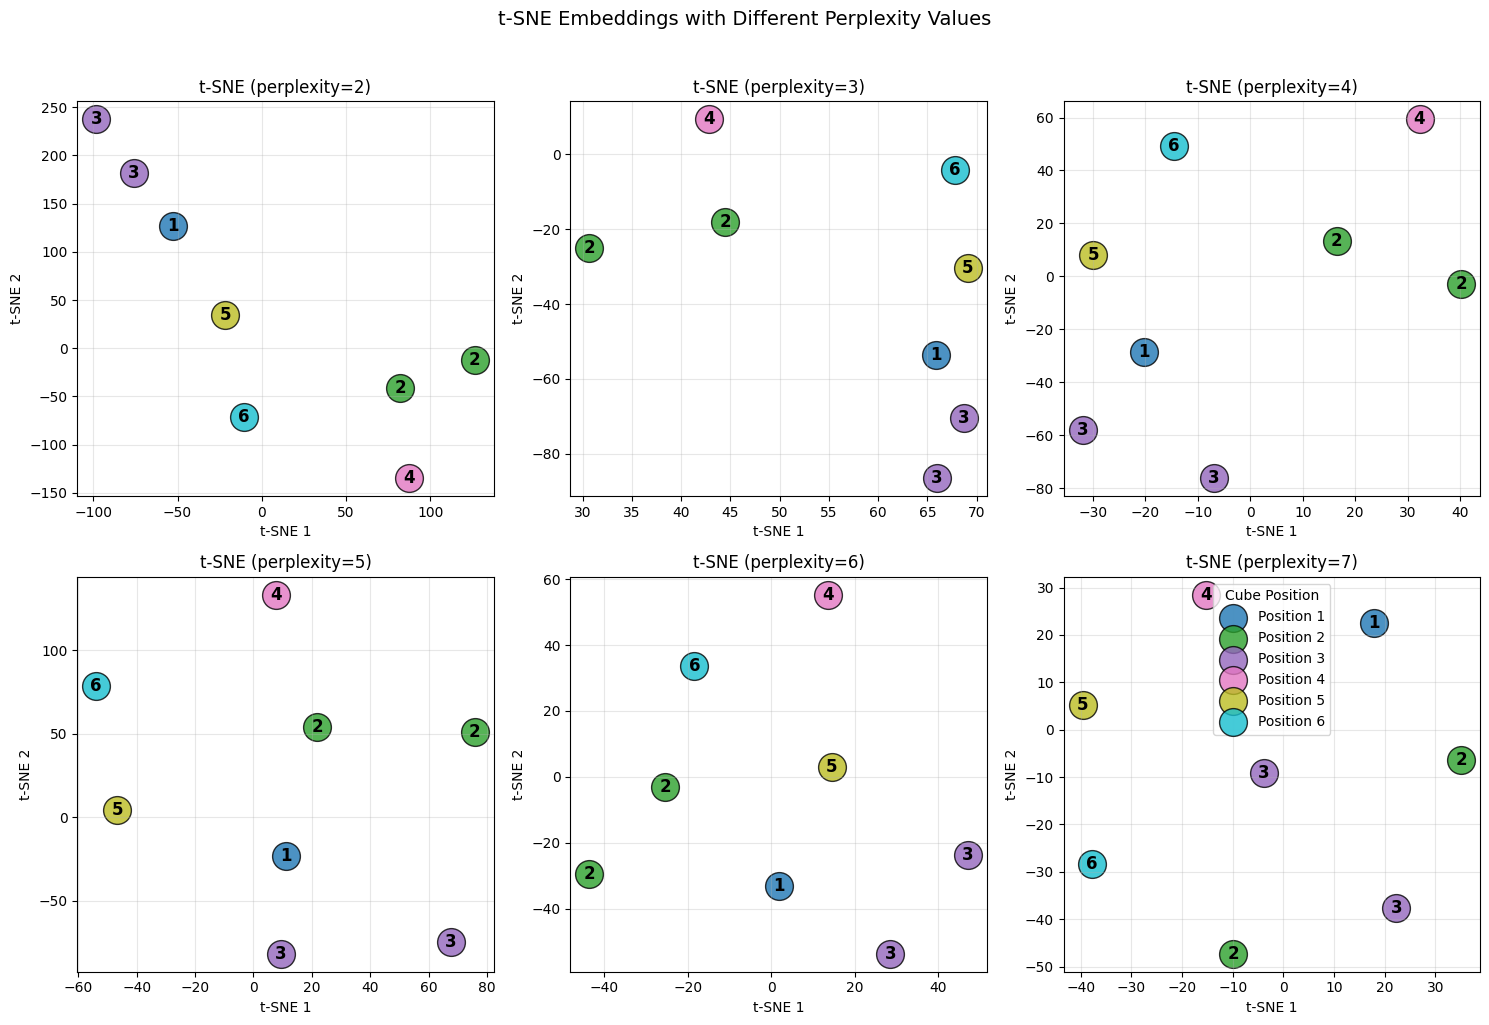

In [24]:
# Try different perplexity values
# Perplexity should be less than n_samples, typically 5-50
perplexities = [2, 3, 4, 5, 6, 7]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

tsne_embeddings = {}

for idx, perp in enumerate(perplexities):
    ax = axes[idx]

    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=perp, random_state=RANDOM_SEED, max_iter=1000)
    X_tsne = tsne.fit_transform(X_pca_pre)
    tsne_embeddings[perp] = X_tsne

    # Plot
    for pos in unique_positions:
        mask = positions == pos
        ax.scatter(
            X_tsne[mask, 0],
            X_tsne[mask, 1],
            c=[color_map[pos]],
            label=f'Position {pos}',
            s=400,
            alpha=0.8,
            edgecolors='black',
            linewidths=1
        )

    # Add position labels
    for i, (x, y) in enumerate(X_tsne):
        ax.text(x, y, str(positions[i]),
                fontsize=12, fontweight='bold',
                ha='center', va='center', color='black')

    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_title(f't-SNE (perplexity={perp})')
    ax.grid(True, alpha=0.3)

# Add legend to last plot
axes[-1].legend(title='Cube Position', loc='best')

plt.suptitle('t-SNE Embeddings with Different Perplexity Values', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## t-SNE 3D Visualization

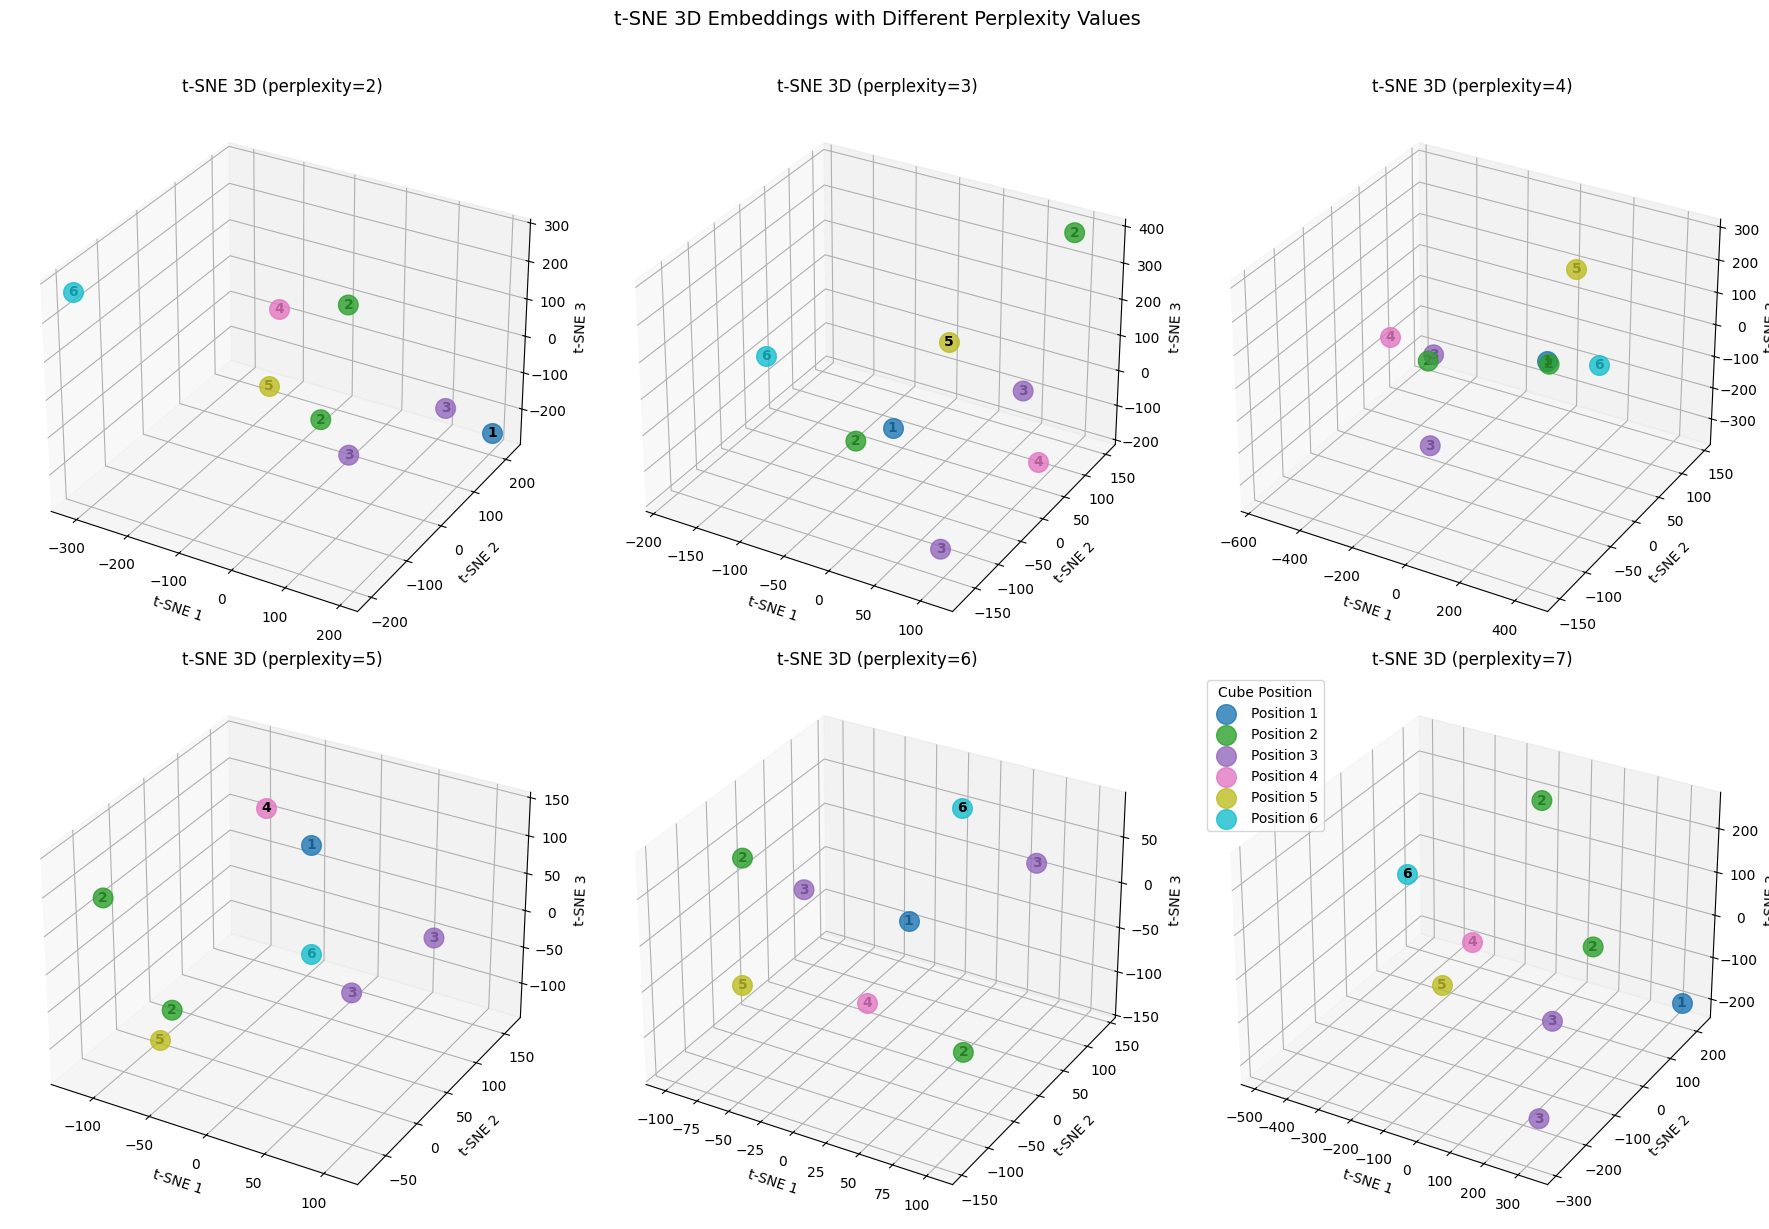

In [25]:
# t-SNE to 3 dimensions with different perplexity values
perplexities_3d = [2, 3, 4, 5, 6, 7]

fig = plt.figure(figsize=(18, 12))

tsne_embeddings_3d = {}

for idx, perp in enumerate(perplexities_3d):
    ax = fig.add_subplot(2, 3, idx + 1, projection='3d')

    # Run t-SNE to 3D
    tsne_3d = TSNE(n_components=3, perplexity=perp, random_state=RANDOM_SEED, max_iter=1000)
    X_tsne_3d = tsne_3d.fit_transform(X_pca_pre)
    tsne_embeddings_3d[perp] = X_tsne_3d

    # Plot
    for pos in unique_positions:
        mask = positions == pos
        ax.scatter(
            X_tsne_3d[mask, 0],
            X_tsne_3d[mask, 1],
            X_tsne_3d[mask, 2],
            c=[color_map[pos]],
            label=f'Position {pos}',
            s=200,
            alpha=0.8
        )

    # Add position labels to each point
    for i in range(len(positions)):
        ax.text(
            X_tsne_3d[i, 0],
            X_tsne_3d[i, 1],
            X_tsne_3d[i, 2],
            str(positions[i]),
            fontsize=10,
            fontweight='bold',
            ha='center',
            va='center',
            color='black'
        )

    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_zlabel('t-SNE 3')
    ax.set_title(f't-SNE 3D (perplexity={perp})')

# Add legend to last plot
ax.legend(title='Cube Position', loc='upper left')

plt.suptitle('t-SNE 3D Embeddings with Different Perplexity Values', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## t-SNE Distance Matrix with Ordering Validation

Varying number of dimensions (like PCA), with fixed perplexity=5.

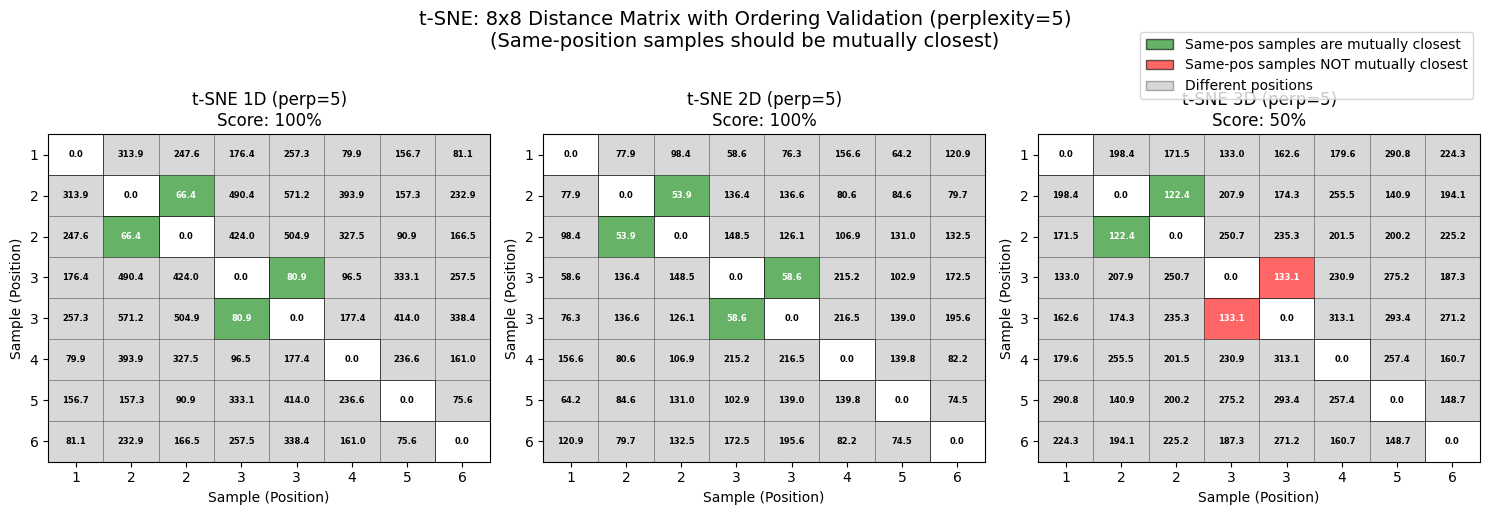


t-SNE Scores by dimension (perplexity=5):
  1D: 100%
  2D: 100%
  3D: 50%


In [26]:
# Distance matrices with ordering validation for t-SNE embeddings
# Vary number of dimensions (1-3) with fixed perplexity=5
# Note: t-SNE Barnes-Hut only supports up to 3 dimensions
TSNE_PERPLEXITY = 5
max_tsne_dims = 3

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

tsne_scores = []
tsne_embeddings_by_dim = {}

for n_dims in range(1, max_tsne_dims + 1):
    ax = axes[n_dims - 1]

    # Run t-SNE to n_dims dimensions
    tsne = TSNE(n_components=n_dims, perplexity=TSNE_PERPLEXITY, random_state=RANDOM_SEED, max_iter=1000)
    X_tsne = tsne.fit_transform(X_pca_pre)
    tsne_embeddings_by_dim[n_dims] = X_tsne

    dist_matrix = compute_sample_distance_matrix(X_tsne)
    score, status_matrix = check_same_position_closest(dist_matrix, positions)
    tsne_scores.append((n_dims, score))

    n_samples = len(sample_labels)

    # Plot with colored cells based on status
    for i in range(n_samples):
        for j in range(n_samples):
            if i == j:
                color, alpha = 'white', 1.0
            elif status_matrix[i, j] == 1:
                color, alpha = 'green', 0.6
            elif status_matrix[i, j] == -1:
                color, alpha = 'red', 0.6
            else:
                color, alpha = 'gray', 0.3

            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                  facecolor=color, alpha=alpha, edgecolor='black', linewidth=0.5)
            ax.add_patch(rect)

            text_color = 'white' if status_matrix[i, j] != 0 else 'black'
            ax.text(j, i, f'{dist_matrix[i, j]:.1f}',
                   ha='center', va='center', color=text_color, fontsize=6, fontweight='bold')

    ax.set_xticks(range(n_samples))
    ax.set_yticks(range(n_samples))
    ax.set_xticklabels(sample_labels)
    ax.set_yticklabels(sample_labels)
    ax.set_xlabel('Sample (Position)')
    ax.set_ylabel('Sample (Position)')
    ax.set_title(f't-SNE {n_dims}D (perp={TSNE_PERPLEXITY})\nScore: {score:.0%}')
    ax.set_xlim(-0.5, n_samples - 0.5)
    ax.set_ylim(n_samples - 0.5, -0.5)

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99))
plt.suptitle(f't-SNE: 8x8 Distance Matrix with Ordering Validation (perplexity={TSNE_PERPLEXITY})\n(Same-position samples should be mutually closest)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nt-SNE Scores by dimension (perplexity={TSNE_PERPLEXITY}):")
for n_dims, score in tsne_scores:
    print(f"  {n_dims}D: {score:.0%}")

## Comparison: PCA vs t-SNE

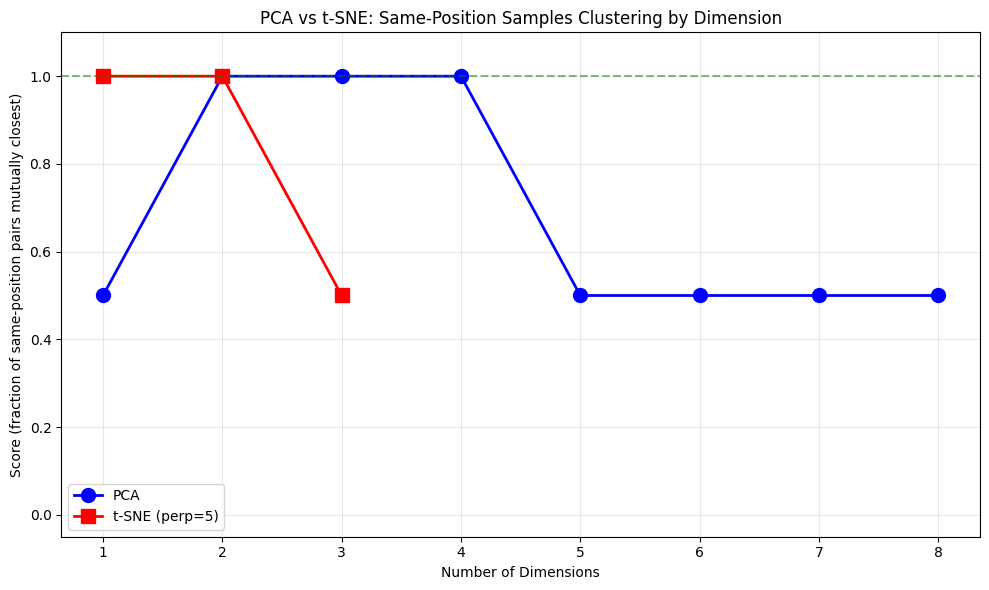


SUMMARY: Same-Position Clustering Score
(Samples from same position should be mutually closest)

PCA:
  1D: 50%
  2D: 100%
  3D: 100%
  4D: 100%
  5D: 50%
  6D: 50%
  7D: 50%
  8D: 50%
  Best: 100% at 2D

t-SNE (perplexity=5, max 3D due to Barnes-Hut):
  1D: 100%
  2D: 100%
  3D: 50%
  Best: 100% at 1D


In [27]:
# Compare PCA and t-SNE scores by number of dimensions
fig, ax = plt.subplots(figsize=(10, 6))

# PCA scores (1-8 dimensions)
pca_x = list(range(1, len(pca_scores) + 1))
ax.plot(pca_x, pca_scores, 'b-o', label='PCA', markersize=10, linewidth=2)

# t-SNE scores (1-3 dimensions only, due to Barnes-Hut limitation)
tsne_x = [d for d, _ in tsne_scores]
tsne_y = [s for _, s in tsne_scores]
ax.plot(tsne_x, tsne_y, 'r-s', label=f't-SNE (perp={TSNE_PERPLEXITY})', markersize=10, linewidth=2)

ax.set_xlabel('Number of Dimensions')
ax.set_ylabel('Score (fraction of same-position pairs mutually closest)')
ax.set_title('PCA vs t-SNE: Same-Position Samples Clustering by Dimension')
ax.set_ylim(-0.05, 1.1)
ax.set_xticks(range(1, 9))
ax.axhline(y=1.0, color='green', linestyle='--', alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 60)
print("SUMMARY: Same-Position Clustering Score")
print("(Samples from same position should be mutually closest)")
print("=" * 60)
print("\nPCA:")
for n_dims, score in enumerate(pca_scores, 1):
    print(f"  {n_dims}D: {score:.0%}")
print(f"  Best: {max(pca_scores):.0%} at {pca_scores.index(max(pca_scores)) + 1}D")

print(f"\nt-SNE (perplexity={TSNE_PERPLEXITY}, max 3D due to Barnes-Hut):")
for n_dims, score in tsne_scores:
    print(f"  {n_dims}D: {score:.0%}")
best_tsne = max(tsne_scores, key=lambda x: x[1])
print(f"  Best: {best_tsne[1]:.0%} at {best_tsne[0]}D")
print("=" * 60)